# **Visualizing and Testing Data Generation Methods**
In this notebook, we will run an experiment to display the average perturbation effect values that we generate with the 4 different methods we have for perturbation effect generation (other than the method for generating the perturbation effect values, we will be holding everything else the same). 

Recall that we have 4 methods for generating perturbation effect data (see `generate_in_silico_data.ipynb` for more information on these):
1. No Mean Adjustment
2. Standard Mean Adjustment
3. Mean adjustment dependent on all TFs bound to gene in question
4. Mean adjustment dependent on binary relationships between bound and unbound TFs to gene in question.

After understanding what the generated data looks like for each of these methods, we will perform another experiment where we train the same model on data generated with each of these methods and compare the model's performance to a simple linear model.

In [1]:
# imports
from yeastdnnexplorer.probability_models.generate_data import (
    generate_gene_population, 
    generate_binding_effects, 
    generate_pvalues, 
    generate_perturbation_effects
)

import torch
import matplotlib.pyplot as plt

from yeastdnnexplorer.probability_models.relation_classes import Relation, And, Or
from yeastdnnexplorer.probability_models.generate_data import (
    default_perturbation_effect_adjustment_function,
    perturbation_effect_adjustment_function_with_tf_relationships,
    perturbation_effect_adjustment_function_with_tf_relationships_boolean_logic
)

from pytorch_lightning import Trainer, LightningModule, seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger, TensorBoardLogger
from torchsummary import summary

from yeastdnnexplorer.data_loaders.synthetic_data_loader import SyntheticDataLoader
from yeastdnnexplorer.ml_models.simple_model import SimpleModel
from yeastdnnexplorer.ml_models.customizable_model import CustomizableModel

torch.manual_seed(42)  # For CPU
torch.cuda.manual_seed_all(42)  # For all CUDA devices

Seed set to 42


42

## **Generating the Data**

Generating the binding data will be the same as always, see `generate_in_silico_data.ipynb`

In [2]:
n_genes = 3000

bound = [0.5, 0.5, 0.5, 0.5, 0.5]
n_sample = [1, 1, 2, 2, 4]

# this will be a list of length 10 with a GenePopulation object in each element
gene_populations_list = []
for bound_proportion, n_draws in zip(bound, n_sample):
    for _ in range(n_draws):
        gene_populations_list.append(generate_gene_population(n_genes, bound_proportion))
        
# Generate binding data for each gene population
binding_effect_list = [generate_binding_effects(gene_population)
                     for gene_population in gene_populations_list]

# Calculate p-values for binding data
binding_pvalue_list = [generate_pvalues(binding_data) for binding_data in binding_effect_list]

binding_data_combined = [torch.stack((gene_population.labels, binding_effect, binding_pval), dim=1)
                         for gene_population, binding_effect, binding_pval
                         in zip (gene_populations_list, binding_effect_list, binding_pvalue_list)]

# Stack along a new dimension (dim=1) to create a tensor of shape [num_genes, num_TFs, 3]
binding_data_tensor = torch.stack(binding_data_combined, dim=1)

Now we define our experiment, this function will return the average perturbation effects (across n_iterations iterations) for each TF for a specific gene for each of the 4 data generation method we have at our disposal. Due to the randomness in the generated data, we need to find the averages over a number of iterations to get the true common values.

We also need to define dictionaries of TF relationships for our third and fourth methods of generating perturbation data, see `generate_in_silico_data.ipynb` for an explanation of what these represent and how they are used / structured. The documentation in `generate_data.py` may be helpful as well.

In [11]:
# TF relationships
tf_relationships_dict = {
    0: [1],
    1: [8],
    2: [5, 6],
    3: [4],
    4: [5],
    5: [9],
    6: [4],
    7: [1, 4],
    8: [6],
    9: [4],
}

# TF relationships that incorporate boolean logic; this is more complex than
# the simple relationships above  as it implements "and" and "or" operations
tf_relationships_dict_boolean_logic = {
    0: [And(3, 4, 8), Or(3, 7), Or(1, 1)],
    1: [And(5, Or(7, 8))],
    2: [],
    3: [Or(7, 9), And(6, 7)],
    4: [And(1, 2)],
    5: [Or(0, 1, 2, 8, 9)],
    6: [And(0, Or(1, 2))],
    7: [Or(2, And(5, 6, 9))],
    8: [],
    9: [And(6, And(3, Or(0, 9)))],
}

def experiment(n_iterations: int = 10, GENE_IDX: int = 0) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Conducts an experiment by generating perturbation effects for a specific gene over multiple iterations
    using different methods and averaging the results.
    
    :param n_iterations: Number of iterations to perform.
    :type n_iterations: int
    :param GENE_IDX: Index of the gene to analyze.
    :type GENE_IDX: int

    :returns: A tuple containing averaged perturbation effects scores for each method.
    :rtype: Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]
    """
    print("Bound (1) and Unbound (0) Labels for gene " + str(GENE_IDX) + ":")
    print(binding_data_tensor[GENE_IDX, :, 0])

    num_tfs = sum(n_sample)
    
    no_mean_adjustment_scores = torch.zeros(num_tfs)
    normal_mean_adjustment_scores = torch.zeros(num_tfs)
    dep_mean_adjustment_scores = torch.zeros(num_tfs)
    boolean_logic_scores = torch.zeros(num_tfs)

    # we generate perturbation effects for each TF on each iteration and then add them to the running totals
    for i in range(n_iterations):
        # Method 1: Generate perturbation effects without mean adjustment
        perturbation_effects_list_no_mean_adjustment = [generate_perturbation_effects(binding_data_tensor[:, tf_index, :].unsqueeze(1), tf_index=0) 
                                                        for tf_index in range(sum(n_sample))]
        perturbation_effects_list_no_mean_adjustment = torch.stack(perturbation_effects_list_no_mean_adjustment, dim=1)

        # Method 2: Generate perturbation effects with normal mean adjustment
        perturbation_effects_list_normal_mean_adjustment = generate_perturbation_effects(
            binding_data_tensor, 
            max_mean_adjustment=10.0
        )

        # Method 3: Generate perturbation effects with dependent mean adjustment
        perturbation_effects_list_dep_mean_adjustment = generate_perturbation_effects(
            binding_data_tensor, 
            tf_relationships=tf_relationships,
            adjustment_function=perturbation_effect_adjustment_function_with_tf_relationships,
            max_mean_adjustment=10.0,
        )
        
        # Method 4: Generate perturbation effects with binary relations between the TFs
        perturbation_effects_list_boolean_logic = generate_perturbation_effects(
            binding_data_tensor, 
            adjustment_function=perturbation_effect_adjustment_function_with_tf_relationships_boolean_logic,
            tf_relationships=tf_relationships_dict_boolean_logic,
            max_mean_adjustment=10.0,
        )

        # take absolute values since we only care about the magnitude of the effects
        no_mean_adjustment_scores += abs(perturbation_effects_list_no_mean_adjustment[GENE_IDX, :])
        normal_mean_adjustment_scores += abs(perturbation_effects_list_normal_mean_adjustment[GENE_IDX, :])
        dep_mean_adjustment_scores += abs(perturbation_effects_list_dep_mean_adjustment[GENE_IDX, :])
        boolean_logic_scores += abs(perturbation_effects_list_boolean_logic[GENE_IDX, :])

        if (i + 1) % 5 == 0:
            print(f"iteration {i+1} completed")
        
    # divide by the number of iterations to get the averages
    no_mean_adjustment_scores /= n_iterations
    normal_mean_adjustment_scores /= n_iterations
    dep_mean_adjustment_scores /= n_iterations
    boolean_logic_scores /= n_iterations
    
    return no_mean_adjustment_scores, normal_mean_adjustment_scores, dep_mean_adjustment_scores, boolean_logic_scores

In [4]:
GENE_IDX = 0
experiment_results = experiment(n_iterations=50, GENE_IDX=GENE_IDX)

Bound (1) and Unbound (0) Labels for gene 0:
tensor([0., 0., 0., 1., 1., 1., 1., 1., 0., 1.])
iteration 5 completed
iteration 10 completed
iteration 15 completed
iteration 20 completed
iteration 25 completed
iteration 30 completed
iteration 35 completed
iteration 40 completed
iteration 45 completed
iteration 50 completed


## **Visualizing the Results**

Now we plot our results.

Bound (bound) TFs for gene 0 are: [3, 4, 5, 6, 7, 9]
Unbound (unbound) TFs for gene 0 are: [0, 1, 2, 8]
tensor([0., 0., 0., 1., 1., 1., 1., 1., 0., 1.])


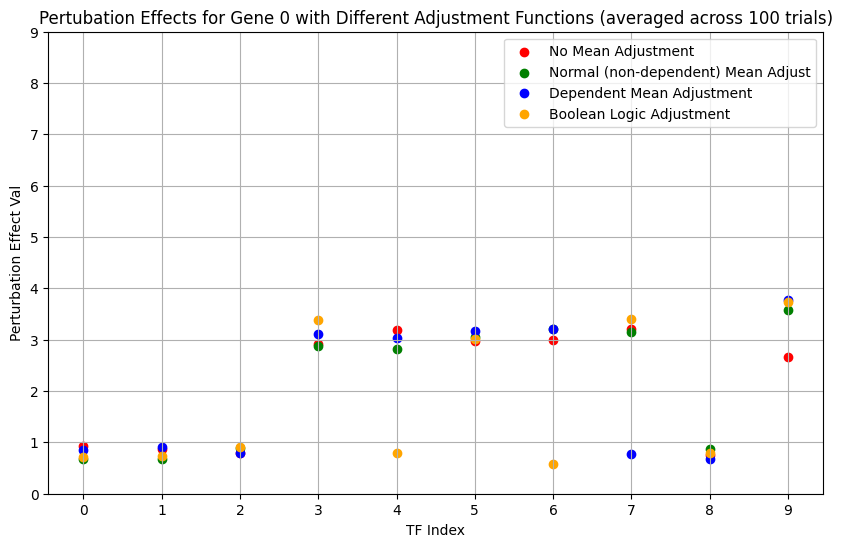

In [5]:
x_vals = list(range(sum(n_sample)))
print("Bound (bound) TFs for gene " + str(GENE_IDX) + " are: " + str(binding_data_tensor[GENE_IDX, :, 0].nonzero().flatten().tolist()))
print("Unbound (unbound) TFs for gene " + str(GENE_IDX) + " are: " + str((1 - binding_data_tensor[GENE_IDX, :, 0]).nonzero().flatten().tolist()))
print(binding_data_tensor[GENE_IDX, :, 0])
plt.figure(figsize=(10, 6))

# Plot each set of experiment results with a different color
colors = ['red', 'green', 'blue', 'orange']
for index, results in enumerate(experiment_results):
    plt.scatter(x_vals, results, color=colors[index])

plt.title('Pertubation Effects for Gene ' + str(GENE_IDX) + ' with Different Adjustment Functions (averaged across 100 trials)')
plt.xlabel('TF Index')
plt.ylabel('Perturbation Effect Val')

#added to compare this to previous graph, REMOVE LATER
plt.ylim(0,9)


plt.xticks(x_vals)
plt.grid(True)
plt.legend(['No Mean Adjustment', 'Normal (non-dependent) Mean Adjust', 'Dependent Mean Adjustment', 'Boolean Logic Adjustment'])
plt.show()

The x-axis labels represent the corresponding TFs whose perturbation effect values are being plotted on the y-axis. The color of each plotted point indicates which of the four data generation methods it was derived from. For example, based on the legend included in the graph, a red point was generated using no mean adjustment. This graph allows us to visualize the perturbation effects for the same TF under a variety of conditions.

Recall that for the dependent mean adjustment, the TF in question must be bound and all of the TFs in its dependency array (in the tf_relationships dictionary) must be bound as well. This is why we do not adjust the mean for TF 7 despite it being bound, it depends on TF 1 and TF 4 both being bound, and TF1 is not bound.

Similarly, for the boolean logic adjustment, we do not adjust the mean for 6 despite it being bound because it depends on (TF0 && (TF1 || TF2)) being bound, and none of those 3 TFs are bound to the gene we are studying.

Note that if you change GENE_IDX, the random seed, or any of the relationship dictionaris that this explanation will no longer apply to the data you are seeing in the plot.

## **Training models on data generated from the 4 different methods**
In the next experiment, we will be training the exact same model on data generated from each of these 4 methods. We will also train a simple linear model on all four methods to use as a baseline to compare to. Other than the method used to generate the data, everything else will be held the same. We define a few helper functions to run our experiment. We make helper functions for things that will mostly be the same across each training loop so that we don't have to keep redefining them.

In [6]:
# define checkpoints and loggers
best_model_checkpoint = ModelCheckpoint(
    monitor="val_explained_variance",
    mode="min",
    filename="best-model-{epoch:02d}-{val_loss:.2f}",
    save_top_k=1,
)

    :param max_mean_adjustment: Maximum mean adjustment value.
    :type max_mean_adjustment: float
    :param adjustment_function: Function to adjust perturbation effects.
    :type adjustment_function: callable
    :param tf_relationships_dict: Dictionary of transcription factor relationships.
    :type tf_relationships_dict: Dict[str, Union[List[int], float]]

    :returns: Configured data loader for synthetic data.
    :rtype: SyntheticDataLoader
    """
    return SyntheticDataLoader(
        batch_size=32,
        num_genes=4000,
        bound_mean=3.0,
        bound=[0.5] * 5,
        n_sample=[1, 1, 2, 2, 4],  # sum of this is num of tfs
        val_size=0.1,
        test_size=0.1,
        random_state=42,
        max_mean_adjustment=max_mean_adjustment,
        adjustment_function=adjustment_function,
        tf_relationships=tf_relationships_dict,
    )

def get_model(num_tfs: int) -> CustomizableModel:
    """
    Creates a customizable model.

    :param num_tfs: Number of transcription factors.
    :type num_tfs: int

    :returns: Configured model.
    :rtype: CustomizableModel
    """
    return CustomizableModel(
        input_dim=num_tfs,
        output_dim=num_tfs,
        lr=0.01,
        hidden_layer_num=2,
        hidden_layer_sizes=[64, 32],
        activation="LeakyReLU",
        optimizer="RMSprop",
        L2_regularization_term=0.0,
        dropout_rate=0.0,
    )

def get_linear_model(num_tfs: int) -> SimpleModel:
    """
    Creates a simple linear model.

    :param num_tfs: Number of transcription factors.
    :type num_tfs: int

    :returns: Configured linear model.
    :rtype: SimpleModel
    """
    return SimpleModel(
        input_dim=num_tfs,
        output_dim=num_tfs,
        lr=0.01
    )

def get_trainer() -> Trainer:
    """
    Creates a trainer for model training.

    :returns: Configured trainer.
    :rtype: Trainer
    """
    return Trainer(
        max_epochs=10,
        deterministic=True,
        accelerator="cpu",
        # The following are turned false to reduce the output in the training cells below. You can toggle them to true to see
        # a model summary and training progress if desired 
        logger=False, 
        enable_progress_bar=False,  
        enable_model_summary=False,  
        enable_checkpointing=False  
    )

def calculate_explained_variance( 
    model: torch.nn.Module, data_module: DataLoader
) -> float:
    """
    Calculates the explained variance of a model's predictions on a test dataset.

    :param test_results: List of test results containing the expected outcomes.
    :type test_results: List[Union[float, int]]
    :param data_module: Data loader for the test dataset.
    :type data_module: DataLoader
    :param model: The model to evaluate.
    :type model: torch.nn.Module

    :returns: The explained variance of the model's predictions.
    :rtype: float
    """
    predictions = []
    targets = []

    model.eval()  # Set the model to evaluation mode
    
    with torch.no_grad():  # Disable gradient calculation
        for batch in data_module.test_dataloader():
            x, y = batch
            outputs = model(x).cpu().numpy()
            predictions.extend(outputs)
            targets.extend(y.cpu().numpy())
    
    # Use scikit-learn to calculate explained variance
    if len(targets) > 0:
        explained_variance = explained_variance_score(targets, predictions)
        return explained_variance
    else:
        return None

# These lists will store the test results for different models and data generation methods
model_ves = []
linear_model_test_ves = []

In [30]:
import torch
from sklearn.metrics import explained_variance_score

data_module = get_data_module(0.0)
num_tfs = sum(data_module.n_sample)
model_ves = []  # List to store explained variance for the non-linear model
linear_model_test_ves = [] # List to store explained variance for the linear model

def calculate_explained_variance(test_results, data_module, model):
    predictions = []
    targets = []

    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():  # Disable gradient calculation
        for batch in data_module.test_dataloader():
             # Assuming your data is in the format (x, y)
            x, y = batch
            outputs = model(x)
            predictions.append(outputs)
            targets.append(y)
    mse = torch.nn.functional.mse_loss(torch.tensor(predictions), torch.tensor(targets)).item()
    var_y = torch.var(torch.tensor(targets)).item() 
    explained_variance = 1 - (mse / var_y)
    return explained_variance 

# # Function to calculate explained variance from test results
# def calculate_explained_variance(test_results, data_module, model):
#     """
#     Calculates the explained variance score using PyTorch and scikit-learn.

#     Args:
#         test_results: The results dictionary from the trainer.test() function.
#         data_module: The data module containing the test dataloader.
#         model: The trained PyTorch model.

#     Returns:
#         float: The explained variance score.
#     """
#     predictions = []
#     targets = []

#     model.eval()  # Set the model to evaluation mode

#     with torch.no_grad():  # Disable gradient calculation
#         for batch in data_module.test_dataloader():
#             # Assuming your data is in the format (x, y)
#             x, y = batch
#             outputs = model(x)
#             predictions.append(outputs)
#             targets.append(y)

#     predictions = torch.cat(predictions, dim=0).numpy()  # Concatenate predictions
#     targets = torch.cat(targets, dim=0).numpy()  # Concatenate targets

#     return explained_variance_score(targets, predictions)

### **1) Train models on data generated with no mean adjustment**
We will first compare the models performances on data generated without any mean adjustments. This is the most simple dataset we will generate, and serves as a good starting point for the models.

In [7]:
import warnings
import logging

# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning, message=".*torch.tensor.*")
warnings.filterwarnings("ignore", category=UserWarning, message=".*DataLoader.*")
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)

In [8]:
# Initialize data module
data_module = get_data_module(0.0)
num_tfs = sum(data_module.n_sample)

# --- Nonlinear Model ---
model = get_model(num_tfs)
trainer = get_trainer()
trainer.fit(model, data_module)
explained_variance = calculate_explained_variance(model, data_module)
model_ves.append(explained_variance)
print("Nonlinear Model Explained Variance:", explained_variance)

# --- Linear Model ---
linear_model = get_linear_model(num_tfs)
trainer = get_trainer()
trainer.fit(linear_model, data_module)
explained_variance_linear = calculate_explained_variance(linear_model, data_module)
linear_model_test_ves.append(explained_variance_linear)

print("Linear Model Explained Variance:", explained_variance_linear)

Nonlinear Model Explained Variance: 0.24550879001617432
Linear Model Explained Variance: -0.00506981611251831


The explained variance for the linear model is surprisingly sightly negative in contrast to the nonlinear, customizable model which yielded a significantly larger positive explained variance. This suggests that the customizable model is able to better account for the distribution of the generated data with no mean adjustments, yielding a significantly higher explained variance. It is interesting to consider whether the same relationship will be observed in the next few conditions as the data generation methods becoome increasingly more complex. 

### **2) Train models on data generated with normal mean adjustments**
Now, let us perform the same comparison but using this condition, with a normal mean adjustment of 3.

In [9]:
data_module = get_data_module(3.0)
num_tfs = sum(data_module.n_sample)

# Nonlinear model
model = get_model(num_tfs)
trainer = get_trainer()
trainer.fit(model, data_module)
explained_variance = calculate_explained_variance(model, data_module)
model_ves.append(explained_variance)
print("Nonlinear Model Explained Variance (Method 2):", explained_variance)

# Linear model
linear_model = get_linear_model(num_tfs)
trainer = get_trainer()
trainer.fit(linear_model, data_module)
explained_variance_linear = calculate_explained_variance(linear_model, data_module)
linear_model_test_ves.append(explained_variance_linear)
print("Linear Model Explained Variance (Method 2):", explained_variance_linear)


Nonlinear Model Explained Variance (Method 2): 0.2549255728721619
Linear Model Explained Variance (Method 2): 0.07210595607757568


Once again, a similar explained variance metric was obtained using both models. However, this time, the simple linear model achieved a positive value, meaning that it was able to somewhat account for the distribution of the data. However, given the difference in explained variance scores, this once again suggests that the nonlinear, customizable model performs substantially better than the simple linear model based on the generated data with a mean adjustment of 3. It seems that the additional parameters in the nonlinear neural network can better accomodate the complexity of the data relatively better than the simple linear model.

### **3) Train models on data generated with dependent mean adjustments**
Now we are implementing a dataset that contains dependent mean adjustments as shown below, with a mean adjustment of 3 if the TF meets the criteria defined by the dictionary.

In [12]:
data_module = get_data_module(3.0, perturbation_effect_adjustment_function_with_tf_relationships, tf_relationships_dict)
num_tfs = sum(data_module.n_sample)

# Nonlinear model
model = get_model(num_tfs)
trainer = get_trainer()
trainer.fit(model, data_module)
explained_variance = calculate_explained_variance(model, data_module)
model_ves.append(explained_variance)
print("Nonlinear Model Explained Variance (Method 3):", explained_variance)

# Linear model
linear_model = get_linear_model(num_tfs)
trainer = get_trainer()
trainer.fit(linear_model, data_module)
explained_variance_linear = calculate_explained_variance(linear_model, data_module)
linear_model_test_ves.append(explained_variance_linear)
print("Linear Model Explained Variance (Method 3):", explained_variance_linear)

Nonlinear Model Explained Variance (Method 3): 0.18576881289482117
Linear Model Explained Variance (Method 3): 0.00479055643081665


It appears once again that the customizable model obtains a more positive and larger explained variance compared to the simple linear model when implementing dependencies among TFs. It is possible that the added layer of complexity makes it more difficult for the simple linear model to make an accurate prediction. Lastly, it would be interesting to consider how the models will perform on data including more complex dependencies that involve binary relations.

### **4) Train models on data generated using the binary relations between TFs**
Similar to the previous condition, we are implementing dependencies between TFs. However, the following dictionary contains simple logic that makes these dependencies far more complex. For example, in order for transcription factor 4 to be perturbed based on the dictionary below, both TFs 1 and 2 need to be considered perturbed in order for this TF to be perturbed as well. Adding this additional layer of complexity will be an interesting challenge: let us see how the two models perform here.

In [13]:
data_module = get_data_module(
    3.0, 
    adjustment_function=perturbation_effect_adjustment_function_with_tf_relationships_boolean_logic, 
    tf_relationships_dict=tf_relationships_dict_boolean_logic)
num_tfs = sum(data_module.n_sample)

# Nonlinear model
model = get_model(num_tfs)
trainer = get_trainer()
trainer.fit(model, data_module)
explained_variance = calculate_explained_variance(model, data_module)
model_ves.append(explained_variance)
print("Nonlinear Model Explained Variance (Method 4):", explained_variance)

# Linear model
linear_model = get_linear_model(num_tfs)
trainer = get_trainer()
trainer.fit(linear_model, data_module)
explained_variance_linear = calculate_explained_variance(linear_model, data_module)
linear_model_test_ves.append(explained_variance_linear)
print("Linear Model Explained Variance (Method 4):", explained_variance_linear)

Nonlinear Model Explained Variance (Method 4): 0.1844494581222534
Linear Model Explained Variance (Method 4): 0.012156563997268676


Once again, our customizable model outperforms the simple linear model in terms of obtaining a higher explained variance. Surprisingly, both models acheive explained variance scores that are somewhat similar to their scores previous when implementing dependencies among TFs. This may be of further interest and could use more research to better determine exactly why this is occurring based on the generated data.

## **Visualizing the Explained Variance**

Now we can plot the results across each of the 4 conditions tested above to visualize how the simple linear model and the nonlinear, customizable model perform compared to one another with regard to their explained variance scores.

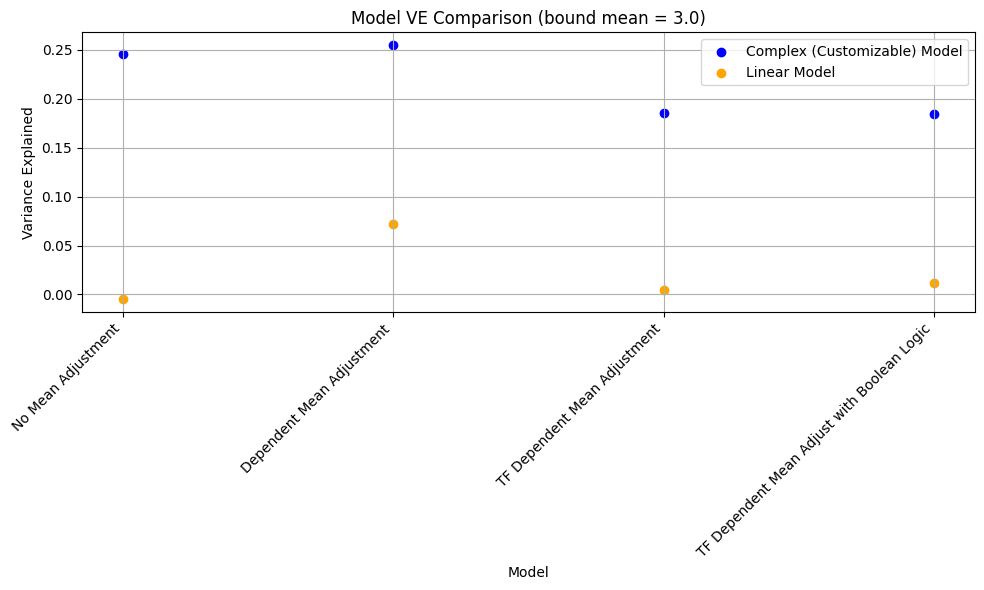

In [14]:
data_gen_methods = ["No Mean Adjustment", "Dependent Mean Adjustment", "TF Dependent Mean Adjustment", "TF Dependent Mean Adjust with Boolean Logic"]
plt.figure(figsize=(10, 6))
plt.scatter(data_gen_methods, model_ves, color='blue')
plt.scatter(data_gen_methods, linear_model_test_ves, color='orange')
plt.title('Model VE Comparison (bound mean = 3.0)')
plt.xlabel('Model')
plt.ylabel('Variance Explained')
plt.grid(True)
plt.xticks(rotation=45, ha="right")
plt.legend(['Complex (Customizable) Model', 'Linear Model'])
plt.tight_layout()
plt.show()

The x-axis labels the method in which the data was generated according to the 4 options above. The y-axis represents the corresponding variance explained attained by these models. Each point represents the variance explained achieved after generating the data based on the x-axis, and the color of the point represents which model architecture was trained on the data resulting in the specificed explained variance. Now, we can clearly see that across the 4 conditions, the nonlinear, customizable model acheives a significantly higher positive explained variance compared to the simple linear model, which is good because it helps to confirm that the nonlinear model we are using is able to train on the data and better account for the distribution of the data, resulting in a higher explained variance compared to the simple linear model. 